<a href="https://colab.research.google.com/github/SETIADEEPANSHU/ExtensiveVisionAIProgramme/blob/master/SEO_Protoype1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
!python3 -m spacy download en

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=d7b935e3dc6be6d78763dce52b6fdfc1e5975883580be86560dfdb3c7ee167f8
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [0]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

## This dataset text can be used to classify text documents


In [39]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.target_names.unique())
df.head()

['rec.motorcycles' 'rec.sport.hockey' 'talk.politics.mideast'
 'soc.religion.christian']


,content,target,target_names
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstein)\nSubject: Re: Recommendation on Duc\nSummary: W...,8,rec.motorcycles
10007,From: jet@netcom.Netcom.COM (J. Eric Townsend)\nSubject: Re: Insurance and lotsa points...\nIn-R...,8,rec.motorcycles
10008,From: gld@cunixb.cc.columbia.edu (Gary L Dare)\nSubject: Re: ABC coverage\nNntp-Posting-Host: cu...,10,rec.sport.hockey
10017,From: nstramer@supergas.dazixco.ingr.com (Naftaly Stramer)\nSubject: Peace talks ...\nNntp-Posti...,17,talk.politics.mideast
10019,From: mussack@austin.ibm.com (Christopher Mussack)\nSubject: Re: Questioning Authority\nLines: 6...,15,soc.religion.christian


In [0]:
temp = df[['target','target_names']].head(30)

In [42]:
temp.sort_values(by=['target'])

,target,target_names
10,8,rec.motorcycles
1013,8,rec.motorcycles
10113,8,rec.motorcycles
10085,8,rec.motorcycles
10078,8,rec.motorcycles
10036,8,rec.motorcycles
10070,8,rec.motorcycles
10007,8,rec.motorcycles
10025,8,rec.motorcycles
10155,10,rec.sport.hockey


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2361 entries, 10 to 9997
Data columns (total 3 columns):
content         2361 non-null object
target          2361 non-null int64
target_names    2361 non-null object
dtypes: int64(1), object(2)
memory usage: 153.8+ KB


In [44]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (Irwin Arnstein) Subject: Re: Recommendation on Duc Summary: Whats it '
 'worth? Distribution: usa Expires: Sat, 1 May 1993 05:00:00 GMT Organization: '
 'CompuTrac Inc., Richardson TX Keywords: Ducati, GTS, How much? Lines: 13 I '
 'have a line on a Ducati 900GTS 1978 model with 17k on the clock. Runs very '
 'well, paint is the bronze/brown/orange faded out, leaks a bit of oil and '
 'pops out of 1st with hard accel. The shop will fix trans and oil leak. They '
 'sold the bike to the 1 and only owner. They want $3495, and I am thinking '
 'more like $3K. Any opinions out there? Please email me. Thanks. It would be '
 'a nice stable mate to the Beemer. Then Ill get a jap bike and call myself '
 'Axis Motors! -- '
 '----------------------------------------------------------------------- '
 '"Tuba" (Irwin) "I honk therefore I am" CompuTrac-Richardson,Tx DoD #0826 '
 '(R75/6) '
 '----------------------------------------------------------------------- ']


In [58]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        yield(gensim.utils.simple_preprocess(str(sent), deacc=True))  # deacc=True removes punctuations
# Convert to list
data = df.content.values.tolist()

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'r

In [46]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'irwin', 'arnstein', 'subject_re', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution_usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson_tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'richardson_

In [59]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [60]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.020*"team" + 0.020*"game" + 0.014*"hockey" + 0.011*"nhl" + 0.010*"player" '
  '+ 0.010*"play" + 0.010*"win" + 0.009*"hawk" + 0.009*"season" + '
  '0.008*"year"'),
 (1,
  '0.020*"armenian" + 0.010*"israel" + 0.009*"israeli" + 0.008*"people" + '
  '0.007*"kill" + 0.006*"article" + 0.006*"state" + 0.006*"government" + '
  '0.005*"turk" + 0.005*"center"'),
 (2,
  '0.010*"people" + 0.008*"god" + 0.007*"time" + 0.007*"christian" + '
  '0.007*"believe" + 0.007*"write" + 0.006*"question" + 0.005*"law" + '
  '0.005*"organization" + 0.005*"way"'),
 (3,
  '0.012*"organization" + 0.011*"write" + 0.010*"article" + 0.009*"bike" + '
  '0.008*"time" + 0.008*"new" + 0.007*"look" + 0.007*"well" + '
  '0.004*"university" + 0.004*"move"')]


In [61]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accel', 1),
  ('arnstein', 1),
  ('axis', 1),
  ('beemer', 1),
  ('bike', 2),
  ('bit', 1),
  ('bronze', 1),
  ('brown', 1),
  ('call', 1),
  ('clock', 1),
  ('computrac', 2),
  ('dod', 1),
  ('duc', 1),
  ('ducati', 2),
  ('email', 1),
  ('expire', 1),
  ('fade', 1),
  ('fix', 1),
  ('gmt', 1),
  ('gt', 2),
  ('hard', 1),
  ('honk', 1),
  ('ill', 1),
  ('inc', 1),
  ('irwin', 2),
  ('jap', 1),
  ('keyword', 1),
  ('leak', 2),
  ('mate', 1),
  ('model', 1),
  ('motor', 1),
  ('much', 1),
  ('oil', 2),
  ('opinion', 1),
  ('orange', 1),
  ('organization', 1),
  ('owner', 1),
  ('paint', 1),
  ('pop', 1),
  ('recommendation', 1),
  ('richardson_tx', 2),
  ('sell', 1),
  ('shop', 1),
  ('sit', 1),
  ('stable', 1),
  ('summary', 1),
  ('therefore', 1),
  ('tran', 1),
  ('tuba', 1),
  ('well', 1),
  ('worth', 1)]]

In [62]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.8895,"organization, write, article, bike, time, new, look, well, university, move","[irwin, arnstein, recommendation, duc, summary, worth, expire, sit, gmt, organization, computrac..."
1,1,3.0,0.6187,"organization, write, article, bike, time, new, look, well, university, move","[eric, townsend, insurance, lotsa_point, reply, message, mon, organization, netcom_online, commu..."
2,2,0.0,0.4592,"team, game, hockey, nhl, player, play, win, hawk, season, year","[gary_dare, reply, gary_dare, organization, phds, hall, caleb, cohen, write, boy, everyone, rip,..."
3,3,1.0,0.6723,"armenian, israel, israeli, people, kill, article, state, government, turk, center","[naftaly_stramer, peace_talk, reply, organization, israeline, today, maariv, report, yesterday, ..."
4,4,2.0,0.7638,"people, god, time, christian, believe, write, question, law, organization, way","[question, authority, trendy, liberal, feminist, tendency, fact, basically, agree, rebut, write,..."
5,5,2.0,0.6385,"people, god, time, christian, believe, write, question, law, organization, way","[harrasse, work, prayer, reply, organization, university, chicago, repeat, emphasize, someone_el..."
6,6,3.0,0.7985,"organization, write, article, bike, time, new, look, well, university, move","[andrew_infante, little_hasty, organization, duke, university, durham, apparently, last, little,..."
7,7,2.0,0.9501,"people, god, time, christian, believe, write, question, law, organization, way","[james_sledd, afterlife, organization, social, science, computing, way, look, die, release, arc,..."
8,8,0.0,0.5294,"team, game, hockey, nhl, player, play, win, hawk, season, year","[canadien, stanley_cup, organization, canada, dean, pereira, write, kind, team, montreal, cup, p..."
9,9,0.0,0.8706,"team, game, hockey, nhl, player, play, win, hawk, season, year","[steve_gallichio, possible, canadian, wc, team, organization, cadkey_inc, point, team, canadian,..."


In [63]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"team" + 0.020*"game" + 0.014*"hockey" + 0.011*"nhl" + 0.010*"player" '
  '+ 0.010*"play" + 0.010*"win" + 0.009*"hawk" + 0.009*"season" + '
  '0.008*"year"'),
 (1,
  '0.020*"armenian" + 0.010*"israel" + 0.009*"israeli" + 0.008*"people" + '
  '0.007*"kill" + 0.006*"article" + 0.006*"state" + 0.006*"government" + '
  '0.005*"turk" + 0.005*"center"'),
 (2,
  '0.010*"people" + 0.008*"god" + 0.007*"time" + 0.007*"christian" + '
  '0.007*"believe" + 0.007*"write" + 0.006*"question" + 0.005*"law" + '
  '0.005*"organization" + 0.005*"way"'),
 (3,
  '0.012*"organization" + 0.011*"write" + 0.010*"article" + 0.009*"bike" + '
  '0.008*"time" + 0.008*"new" + 0.007*"look" + 0.007*"well" + '
  '0.004*"university" + 0.004*"move"')]


How to interpret this?

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

![](https://s3.gifyu.com/images/Inferring-Topic-from-Keywords-1024x666.png)

In [65]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.759973584690506

Coherence Score:  0.4954260508798424


In [66]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9977,"team, game, hockey, nhl, player, play, win, hawk, season, year","[bryan, strouse, nhl, result, game, play, organization, keyword, thursday, night, boxscore, nhl,..."
1,1.0,0.9969,"armenian, israel, israeli, people, kill, article, state, government, turk, center","[serdar_argic, armenian, genocide, muslim, people, article, zuma, reply, article, panos_tamamidi..."
2,2.0,0.9959,"people, god, time, christian, believe, write, question, law, organization, way","[mark_baker, arrogance, christian, reply, mark_baker, organization, previous, article, pixie, wo..."
3,3.0,0.9890,"organization, write, article, bike, time, new, look, well, university, move","[wayne, orwig, flame, exhaust, worwig, atlantaga, ncr, com, organization, ncr, corporation, news..."


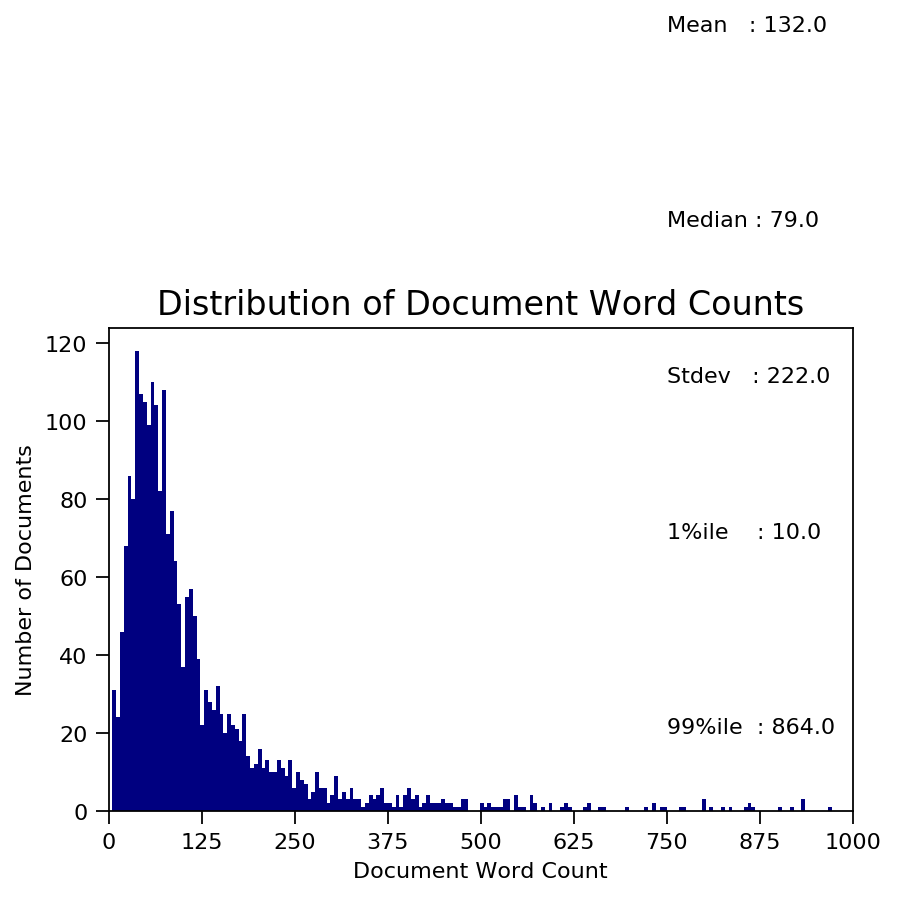

In [67]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(6,4), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 200, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  150, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  110, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  20, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=6)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=15))
plt.show()

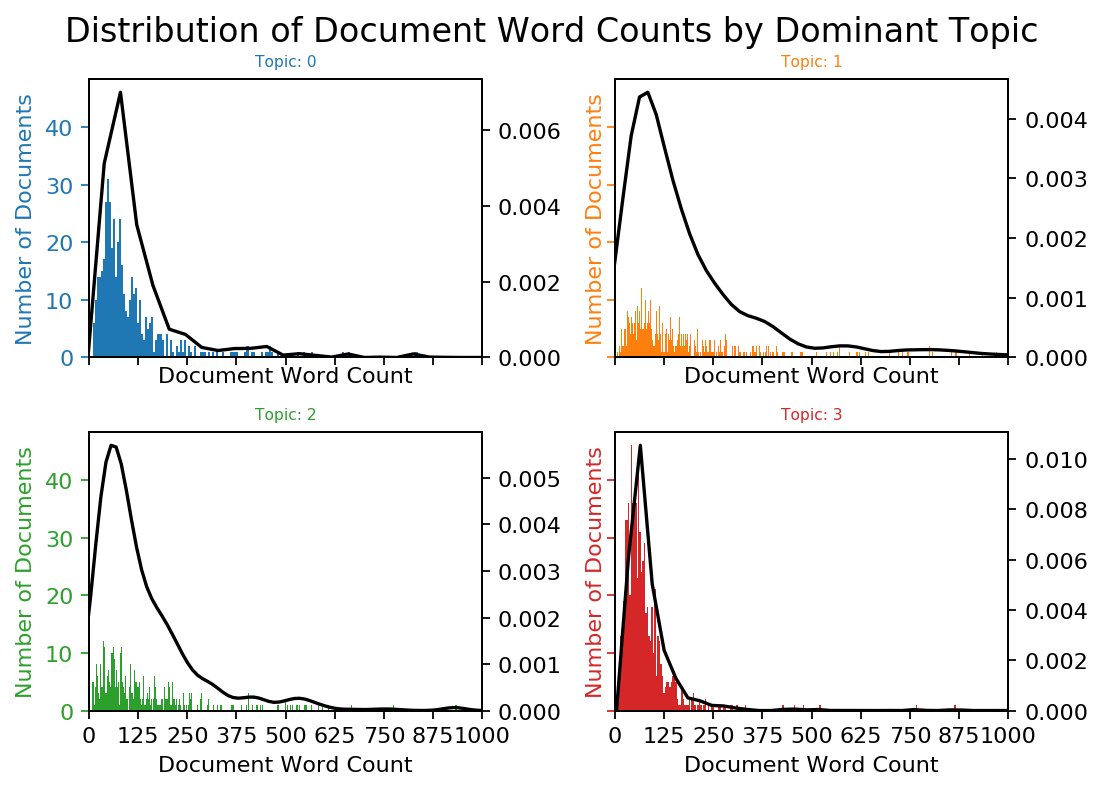

In [68]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(7,5), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=7, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=15)
plt.show()

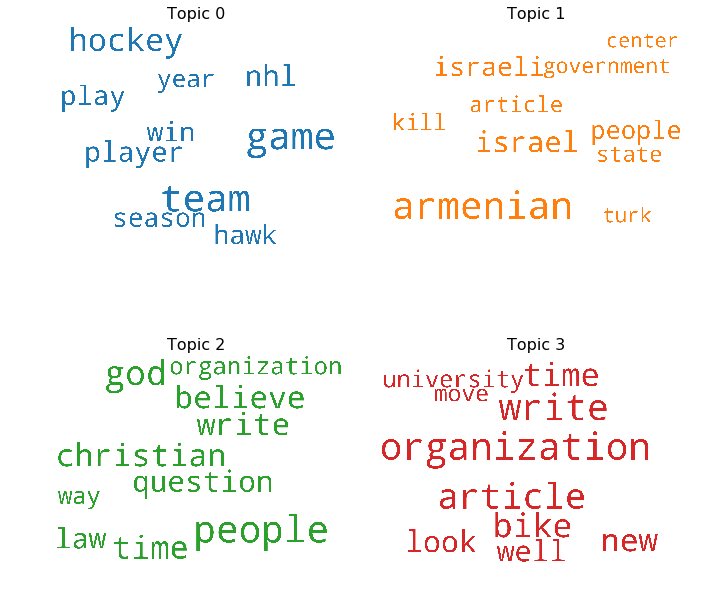

In [69]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

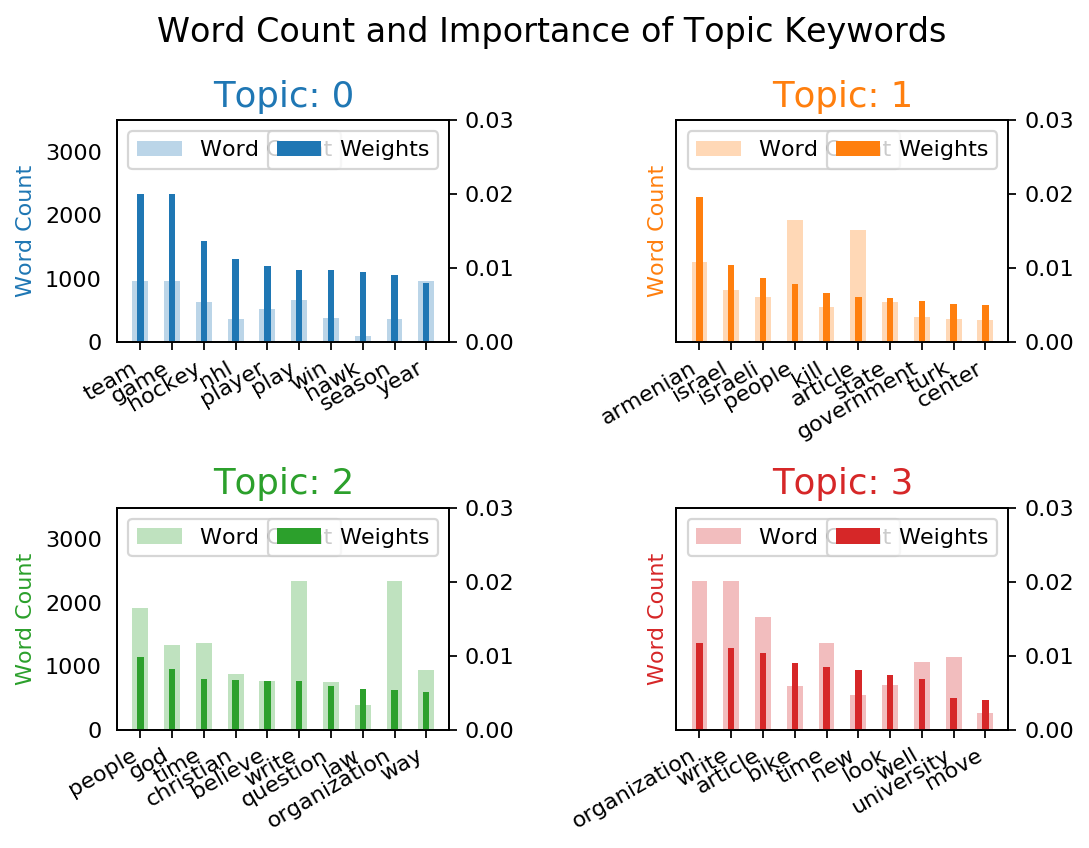

In [72]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(7,5), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=15, y=1.05)    
plt.show()

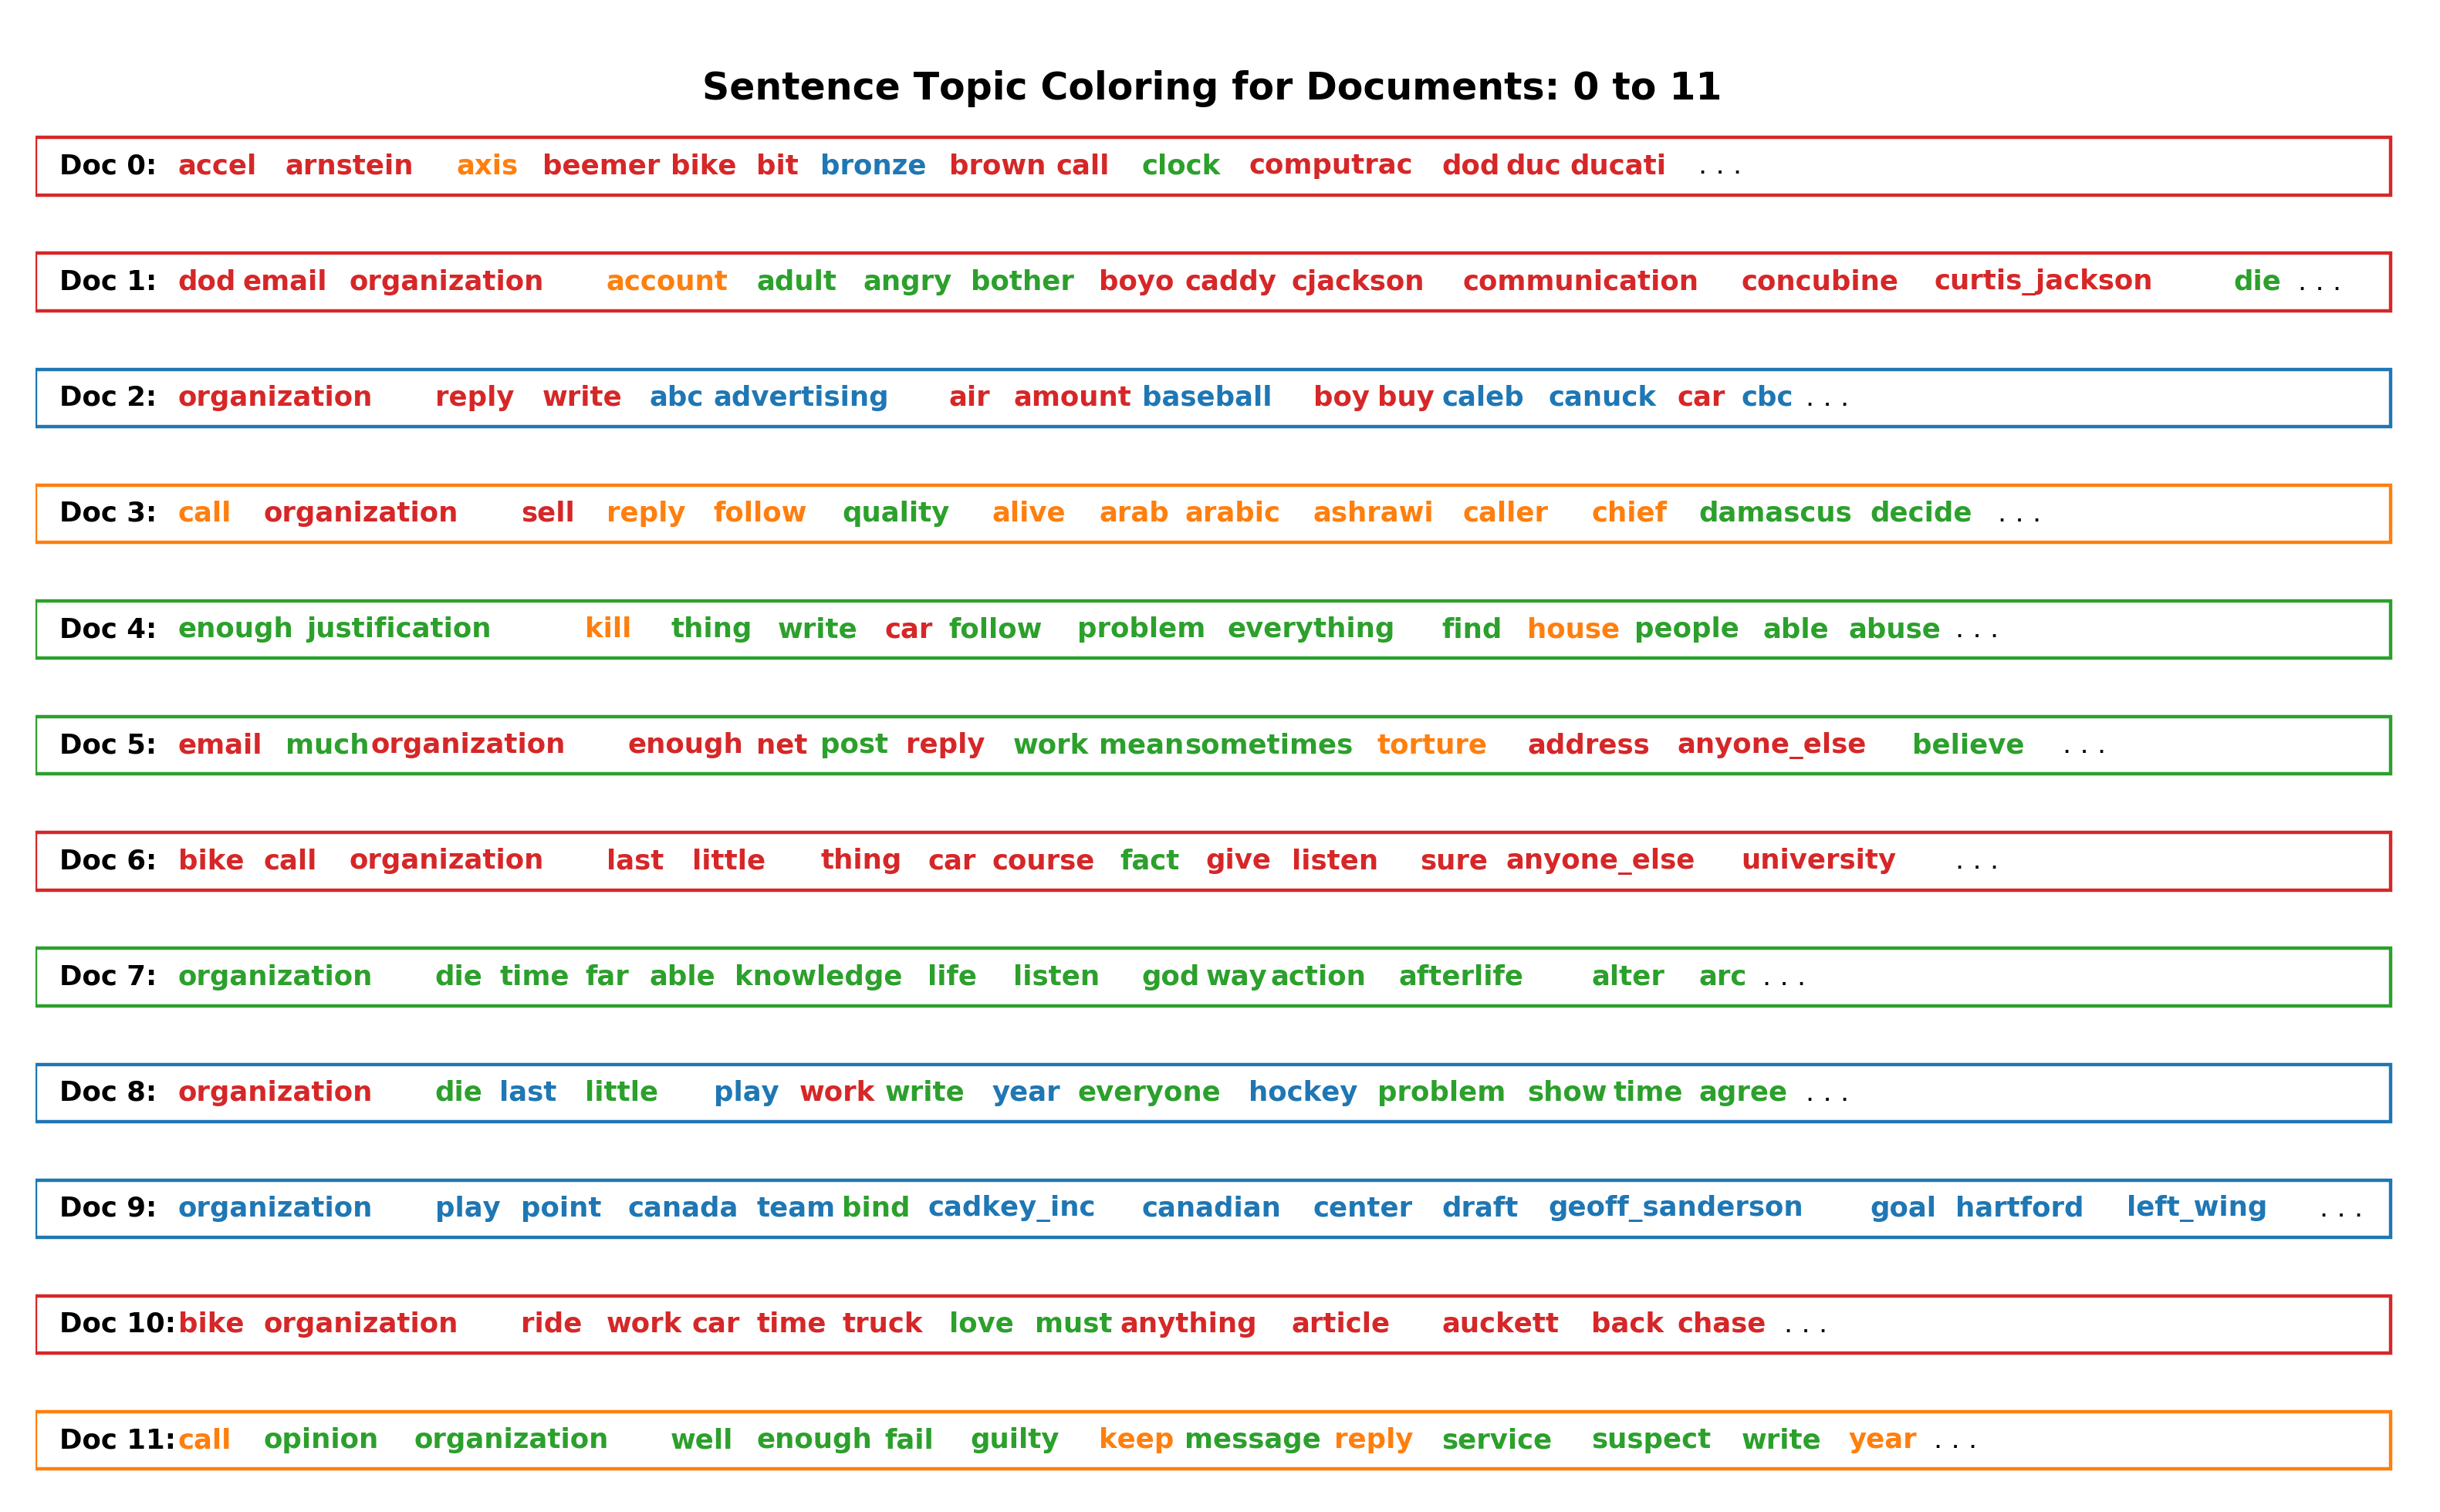

In [75]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() 

In [0]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

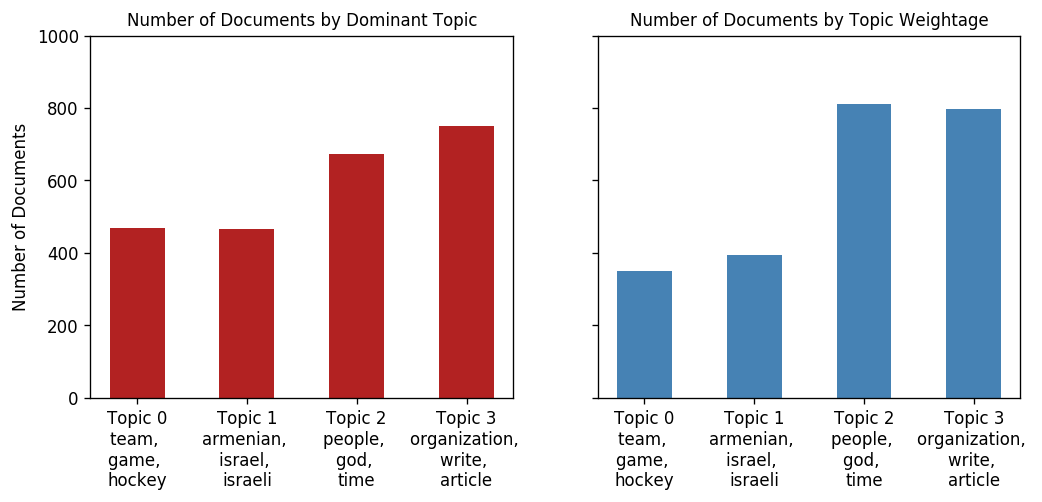

In [77]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [79]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2352 samples in 0.001s...
[t-SNE] Computed neighbors for 2352 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2352
[t-SNE] Computed conditional probabilities for sample 2000 / 2352
[t-SNE] Computed conditional probabilities for sample 2352 / 2352
[t-SNE] Mean sigma: 0.024311
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.363136
[t-SNE] KL divergence after 1000 iterations: 0.477335


In [0]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [83]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.176332 -0.098347       1        1  37.280354
3      0.044636 -0.171516       2        1  25.342518
1      0.117619  0.255081       3        1  23.631319
0     -0.338587  0.014782       4        1  13.745811, topic_info=      Category         Freq          Term        Total  loglift  logprob
1479   Default  1447.000000      armenian  1447.000000  30.0000  30.0000
521    Default   858.000000          team   858.000000  29.0000  29.0000
1180   Default   858.000000          game   858.000000  28.0000  28.0000
155    Default   588.000000        hockey   588.000000  27.0000  27.0000
706    Default   773.000000        israel   773.000000  26.0000  26.0000
4      Default   712.000000          bike   712.000000  25.0000  25.0000
1408   Default   484.000000           nhl   484.000000  24.0000  24.0000
2283   Default   646.000000       israeli   646.000000  23.0000  23.0000
391    Default   946.000000           god   946.000000  22.0000  22.0000
2488   Default   445.000000        player   445.000000  21.0000  21.0000
230    Default  1720.000000        people  1720.000000  20.0000  20.0000
97     Default   421.000000          play   421.000000  19.0000  19.0000
524    Default   418.000000           win   418.000000  18.0000  18.0000
2907   Default   408.000000          hawk   408.000000  17.0000  17.0000
544    Default   390.000000        season   390.000000  16.0000  16.0000
965    Default   784.000000     christian   784.000000  15.0000  15.0000
379    Default   769.000000       believe   769.000000  14.0000  14.0000
87     Default   489.000000          kill   489.000000  13.0000  13.0000
467    Default   714.000000          look   714.000000  12.0000  12.0000
324    Default   841.000000           new   841.000000  11.0000  11.0000
718    Default   635.000000           law   635.000000  10.0000  10.0000
676    Default   408.000000    government   408.000000   9.0000   9.0000
1064   Default   591.000000          book   591.000000   8.0000   8.0000
49     Default   999.000000          well   999.000000   7.0000   7.0000
1644   Default   379.000000          turk   379.000000   6.0000   6.0000
188    Default  1533.000000          time  1533.000000   5.0000   5.0000
2479   Default   263.000000        league   263.000000   4.0000   4.0000
1542   Default   361.000000      genocide   361.000000   3.0000   3.0000
417    Default   523.000000          talk   523.000000   2.0000   2.0000
193    Default   352.000000          arab   352.000000   1.0000   1.0000
...        ...          ...           ...          ...      ...      ...
10096   Topic4   154.861084            sj   155.540070   1.9801  -5.6242
4917    Topic4   154.538193           det   155.216751   1.9801  -5.6263
4962    Topic4   153.843719           pit   154.523422   1.9800  -5.6308
4985    Topic4   151.121017           tor   151.800018   1.9800  -5.6486
3896    Topic4   150.671341           stl   151.349854   1.9799  -5.6516
1275    Topic4   155.714996    pittsburgh   156.422470   1.9799  -5.6187
4905    Topic4   146.954971           buf   147.632889   1.9798  -5.6766
1376    Topic4   156.821899    defenseman   157.587997   1.9796  -5.6116
4470    Topic4   182.313812        norris   183.221878   1.9795  -5.4610
1903    Topic4   131.614395           chi   132.293304   1.9793  -5.7868
3743    Topic4   132.500244       detroit   133.183731   1.9793  -5.7801
8462    Topic4   133.220673           har   133.911057   1.9793  -5.7747
4303    Topic4   144.991959           ahl   145.744308   1.9793  -5.6900
1394    Topic4   132.821930           ice   133.523285   1.9792  -5.7777
8482    Topic4   127.734711           phi   128.415253   1.9791  -5.8168
4964    Topic4   126.150887           que   126.830139   1.9791  -5.8292
2907    Topic4   405.817291          hawk   408.077026   1.9789  -4.6608
2137    Topic4   139.848465         coach   140.699432  